In [64]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# Load the data set
file_path = "order_history_kaggle_data.csv"
df = pd.read_csv(file_path)

In [3]:
# Display basic info
print("Dataset Overview:")
print(df.info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21321 entries, 0 to 21320
Data columns (total 29 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Restaurant ID                                       21321 non-null  int64  
 1   Restaurant name                                     21321 non-null  object 
 2   Subzone                                             21321 non-null  object 
 3   City                                                21321 non-null  object 
 4   Order ID                                            21321 non-null  int64  
 5   Order Placed At                                     21321 non-null  object 
 6   Order Status                                        21321 non-null  object 
 7   Delivery                                            21321 non-null  object 
 8   Distance                                            21321 

In [4]:
# Drop rows with missing target
df = df.dropna(subset=["Rider wait time (minutes)"])

In [5]:
# Clean 'Distance' column (convert km text to float)
df["Distance"] = df["Distance"].str.replace("km", "").str.replace("<1", "0.5").astype(float)

In [6]:
# Parse datetime
df["Order Placed At"] = pd.to_datetime(df["Order Placed At"], errors="coerce")

/tmp/ipykernel_150/2423390741.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Order Placed At"] = pd.to_datetime(df["Order Placed At"], errors="coerce")


In [7]:
# Feature engineering from datetime
df["hour"] = df["Order Placed At"].dt.hour
df["dayofweek"] = df["Order Placed At"].dt.dayofweek

In [8]:
# Drop high-cardinality or irrelevant columns
drop_cols = [
    "Restaurant ID", "Restaurant name", "Order ID", "Items in order",
    "Instructions", "Review", "Cancellation / Rejection reason",
    "Restaurant compensation (Cancellation)", "Restaurant penalty (Rejection)",
    "Order Ready Marked", "Customer complaint tag", "Customer ID", "Order Placed At"
]
df = df.drop(columns=drop_cols)

In [9]:
# Select features and target
target = "Rider wait time (minutes)"
X = df.drop(columns=[target])
y = df[target]

In [10]:
# Separate features by type
numeric_features = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

In [11]:
# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

In [12]:
# Final output: preprocessed training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((16922, 17), (4231, 17), (16922,), (4231,))

In [13]:
# Check for missing values in the dataset (after initial preprocessing)
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

In [14]:
# Display columns with missing values
missing_values

Rating                    18671
Discount construct         5431
KPT duration (minutes)      190
dtype: int64

In [15]:
# Fill missing values
df["Rating"] = df["Rating"].fillna(df["Rating"].median())
df["Discount construct"] = df["Discount construct"].fillna("Unknown")
df["KPT duration (minutes)"] = df["KPT duration (minutes)"].fillna(df["KPT duration (minutes)"].mean())

In [16]:
# Check for duplicate rows and remove them
df.drop_duplicates(inplace=True)

In [17]:
# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
           Distance  Bill subtotal  Packaging charges  \
count  21153.000000   21153.000000       21153.000000   
mean       4.168298     749.099221          32.537225   
std        2.994190     493.717695          22.054447   
min        0.500000      50.000000           2.500000   
25%        2.000000     459.000000          18.450000   
50%        3.000000     629.000000          28.450000   
75%        6.000000     899.000000          39.950000   
max       21.000000   16080.000000         603.000000   

       Restaurant discount (Promo)  \
count                 21153.000000   
mean                     64.983634   
std                      83.644449   
min                       0.000000   
25%                       0.000000   
50%                      80.000000   
75%                     100.000000   
max                    4020.000000   

       Restaurant discount (Flat offs, Freebies & others)  Gold discount  \
count                                       21

In [18]:
# Display the first few rows of the cleaned data set
df.head()

,Subzone,City,Order Status,Delivery,Distance,Discount construct,Bill subtotal,Packaging charges,Restaurant discount (Promo),"Restaurant discount (Flat offs, Freebies & others)",Gold discount,Brand pack discount,Total,Rating,KPT duration (minutes),Rider wait time (minutes),hour,dayofweek
0,Sector 4,Delhi NCR,Delivered,Zomato Delivery,3.0,40% off upto Rs.80,715.0,31.75,80.0,0.0,0.0,0.0,666.75,5.0,18.35,11.6,23,1
1,Sector 4,Delhi NCR,Delivered,Zomato Delivery,2.0,Flat Rs.175 off,1179.0,50.20,175.0,0.0,0.0,0.0,1054.20,5.0,16.95,3.6,23,1
2,Sector 4,Delhi NCR,Delivered,Zomato Delivery,0.5,40% off upto Rs.80,310.0,11.50,80.0,0.0,0.0,0.0,241.50,5.0,14.05,12.2,15,1
3,Sector 4,Delhi NCR,Delivered,Zomato Delivery,2.0,40% off upto Rs.80,620.0,27.00,80.0,0.0,0.0,0.0,567.00,4.0,19.00,3.3,15,1
4,Sector 4,Delhi NCR,Delivered,Zomato Delivery,2.0,40% off upto Rs.80,584.0,25.20,80.0,0.0,0.0,0.0,529.20,5.0,15.97,1.0,15,1


In [19]:
# Display the row and column count of the cleaned data set
df.shape

(21153, 18)

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


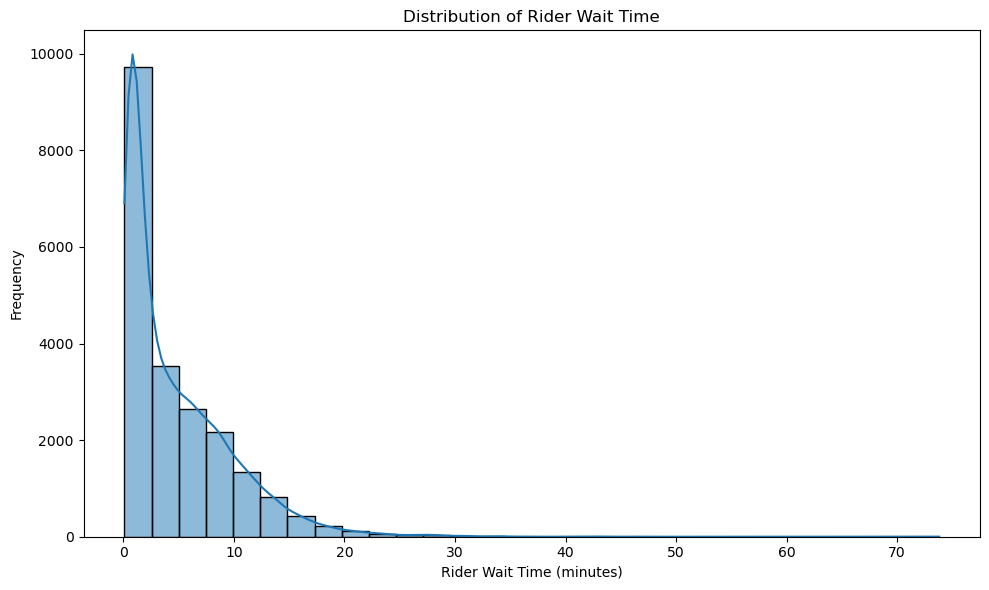

In [20]:
# Distribution of Rider Wait Time
plt.figure(figsize=(10, 6))
sns.histplot(df["Rider wait time (minutes)"], bins=30, kde=True)
plt.title("Distribution of Rider Wait Time")
plt.xlabel("Rider Wait Time (minutes)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

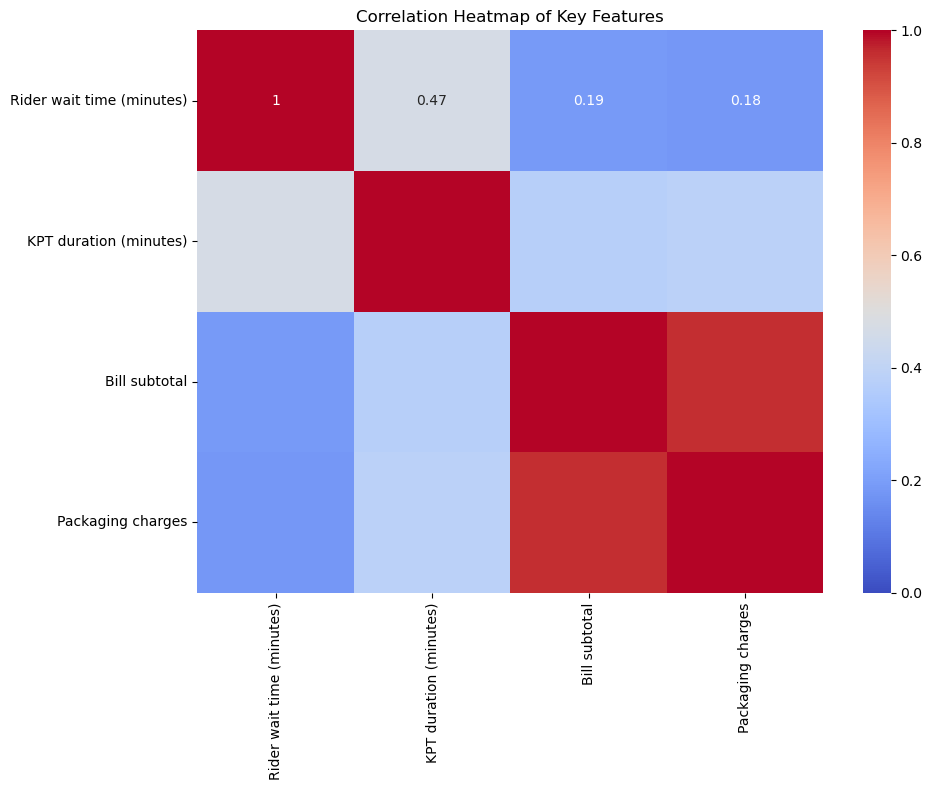

In [21]:
# Correlation Heatmap of Key Features
plt.figure(figsize=(10, 8))
key_features = [
    "Rider wait time (minutes)",
    "KPT duration (minutes)",
    "Bill subtotal",
    "Packaging charges"
]
corr = df[key_features].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlation Heatmap of Key Features")
plt.tight_layout()
plt.show()

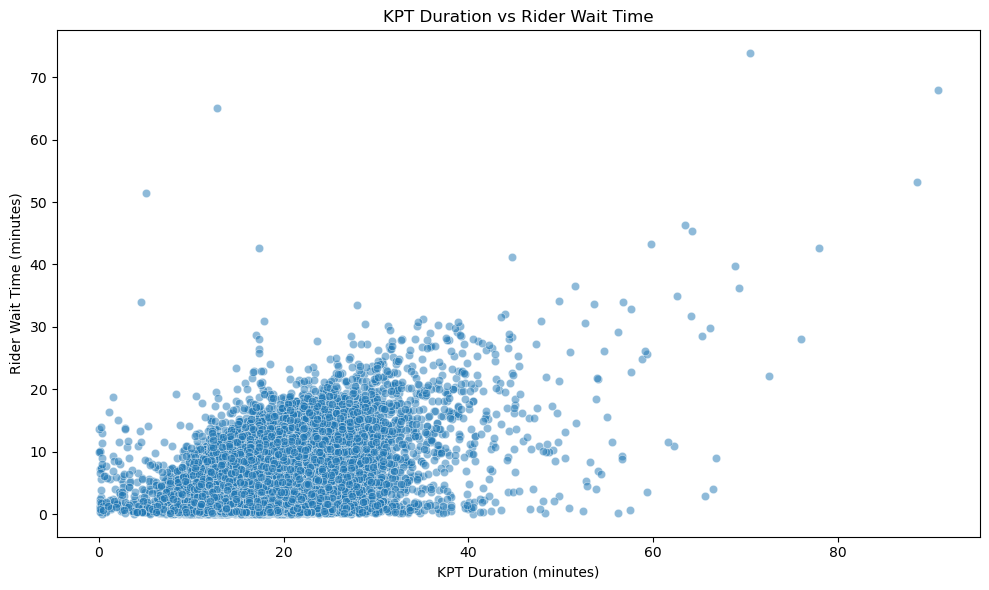

In [22]:
# Scatter Plot of KPT Duration vs Rider Wait Time
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="KPT duration (minutes)", y="Rider wait time (minutes)", alpha=0.5)
plt.title("KPT Duration vs Rider Wait Time")
plt.xlabel("KPT Duration (minutes)")
plt.ylabel("Rider Wait Time (minutes)")
plt.tight_layout()
plt.show()

In [23]:
# Combine preprocessing and model into one pipeline
model_pipeline = make_pipeline(preprocessor, LinearRegression())

In [24]:
# Fit the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Distance', 'Bill subtotal',
                                                   'Packaging charges',
                                                   'Restaurant discount '
                                                   '(Promo)',
                                                   'Restaurant discount (Flat '
                                                   'offs, Freebies & others)',
                                                   'Gold discount',
                                                   'Brand pack discount',
                                                   'Total', 'Rating',
                                                   'KPT duration (minutes)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Subzone', 'City',
                                                   'Order Status', 'Delivery',
                                                   'Discount construct'])])),
                ('linearregression', LinearRegression())])

In [25]:
# Predict on the test set
y_pred = model_pipeline.predict(X_test)

In [26]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [27]:
# MSE Score
print(mse)

17.470051623920728


In [28]:
# RMSE Score
print(rmse)

4.179719084330995


In [29]:
# MAE Score
print(mae)

3.204926369162718


In [30]:
# R2 Score
print(r2)

0.26750851697022004


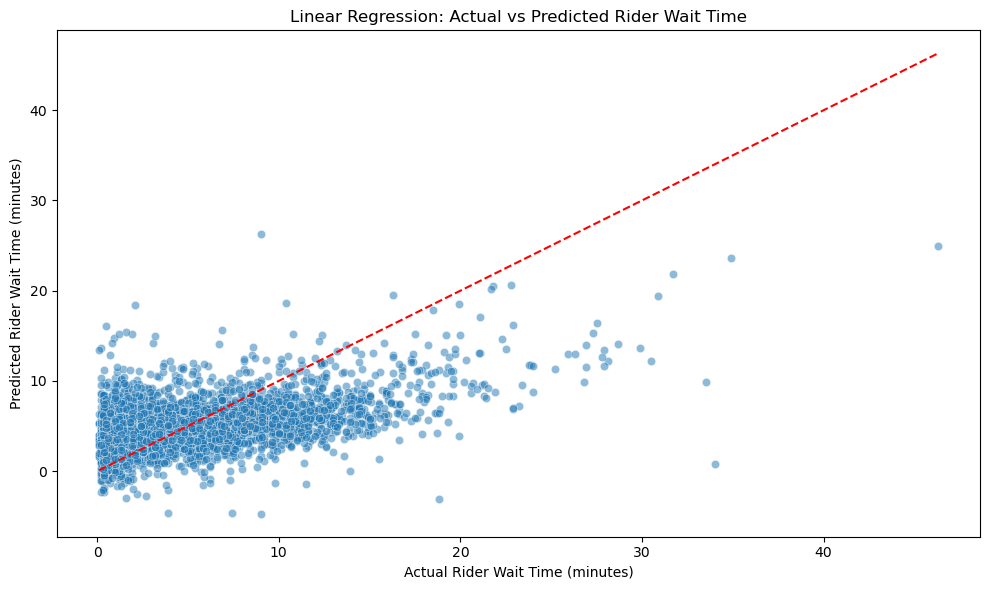

In [31]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")  # Line y=x
plt.xlabel("Actual Rider Wait Time (minutes)")
plt.ylabel("Predicted Rider Wait Time (minutes)")
plt.title("Linear Regression: Actual vs Predicted Rider Wait Time")
plt.tight_layout()
plt.show()

In [32]:
# Random Forest pipeline
rf_pipeline = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, random_state=42))
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Distance', 'Bill subtotal',
                                                   'Packaging charges',
                                                   'Restaurant discount '
                                                   '(Promo)',
                                                   'Restaurant discount (Flat '
                                                   'offs, Freebies & others)',
                                                   'Gold discount',
                                                   'Brand pack discount',
                                                   'Total', 'Rating',
                                                   'KPT duration (minutes)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Subzone', 'City',
                                                   'Order Status', 'Delivery',
                                                   'Discount construct'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [33]:
# Predict
y_pred_rf = rf_pipeline.predict(X_test)

In [34]:
# Evaluate Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

In [35]:
# MSE Score
print(mse_rf)

18.27830930603918


In [36]:
# MAE Score
print(mae_rf)

3.2299037000146313


In [37]:
# R2 Score
print(r2_rf)

0.233619557682057


In [38]:
# RMSE Score
print(rmse_rf)

4.275313942395246


In [41]:
# Extract feature names after preprocessing
feature_names = rf_pipeline.named_steps['columntransformer'].get_feature_names_out()
importances = rf_pipeline.named_steps['randomforestregressor'].feature_importances_

In [43]:
# Create a DataFrame
feat_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_features = feat_importance.sort_values(by='Importance', ascending=False).head(10)

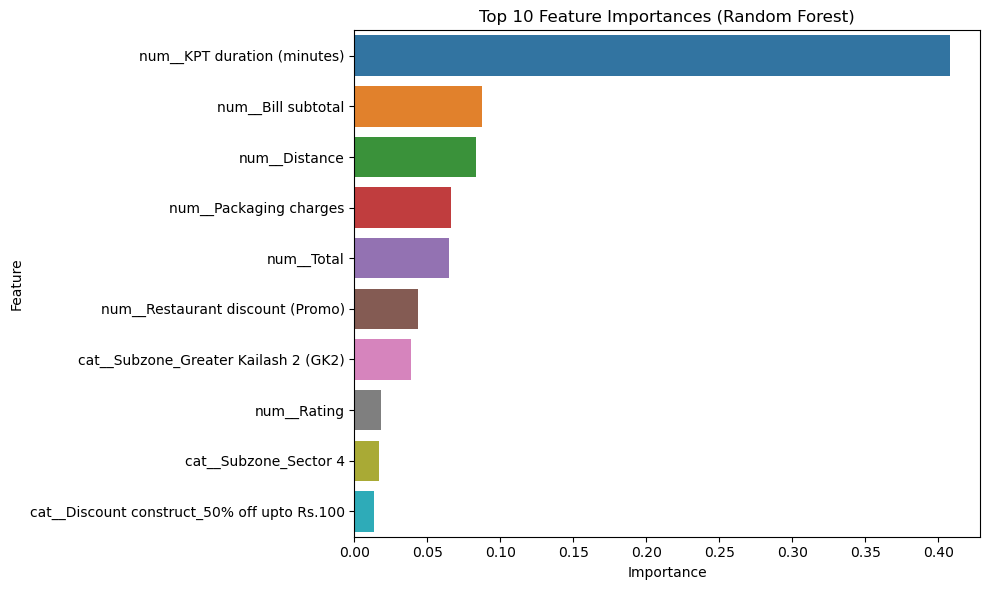

In [44]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=top_features)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

In [65]:
# Create pipeline using GradientBoostingRegressor
gbr_pipeline = make_pipeline(
    preprocessor,
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
)

In [66]:
# Fit model
gbr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Distance', 'Bill subtotal',
                                                   'Packaging charges',
                                                   'Restaurant discount '
                                                   '(Promo)',
                                                   'Restaurant discount (Flat '
                                                   'offs, Freebies & others)',
                                                   'Gold discount',
                                                   'Brand pack discount',
                                                   'Total', 'Rating',
                                                   'KPT duration (minutes)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Subzone', 'City',
                                                   'Order Status', 'Delivery',
                                                   'Discount construct'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=42))])

In [67]:
# Predict
y_pred_gbr = gbr_pipeline.predict(X_test)

In [68]:
# Evaluate Gradient Boosted Model
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = mean_squared_error(y_test, y_pred_gbr, squared=False)
r2_gbr = r2_score(y_test, y_pred_gbr)

In [69]:
# MSE Score
print(mse_gbr)

16.900304250971054


In [70]:
# MAE score
print(mae_gbr)

3.1657068611709698


In [71]:
# RMSE Score
print(rmse_gbr)

4.1109979629003774


In [72]:
# R2 Score
print(r2_gbr)

0.29139711828338366


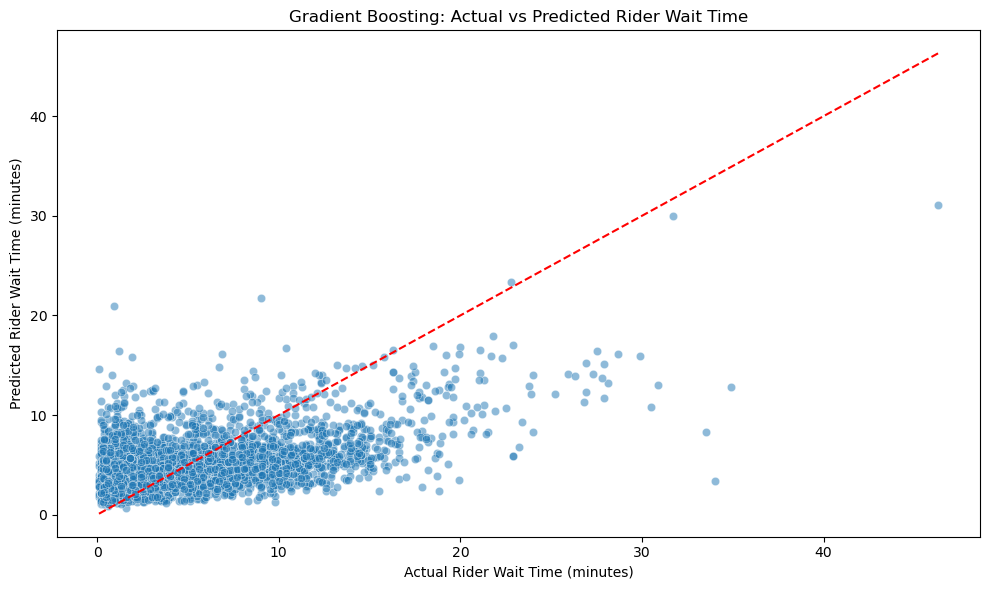

In [73]:
# Actual vs Predicted Scatter Plot for Gradient Boosting Regressor
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_gbr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual Rider Wait Time (minutes)")
plt.ylabel("Predicted Rider Wait Time (minutes)")
plt.title("Gradient Boosting: Actual vs Predicted Rider Wait Time")
plt.tight_layout()
plt.show()